In [3]:
# 1) RECORDING LIST
history = []

# 2) IMPORTS
import numpy as np
from itertools import permutations
import tsp.core.solvers as solvers   # we will override its insertion routine

# 3) WRAPPER FOR CHEAPEST INSERTION
def recorded_cheapest_insertion(
    centroids: np.ndarray,
    nodes: list[int],
    prev_centroid: int | None = None,
    next_centroid: int | None = None
):
    best_cost = float("inf")
    best_idx  = None
    candidates = []

    # try every possible ordering of `nodes`
    for idx, perm in enumerate(permutations(nodes)):
        # build full tour including any fixed endpoints
        tour = list(perm)
        if prev_centroid is not None:
            tour = [prev_centroid] + tour
        if next_centroid is not None:
            tour = tour + [next_centroid]

        # compute its length
        cost = sum(
            np.linalg.norm(centroids[a] - centroids[b])
            for a, b in zip(tour, tour[1:])
        )

        candidates.append((list(perm), cost))
        if cost < best_cost:
            best_cost = cost
            best_idx  = idx

    # record this step
    history.append((
        centroids.copy(),   # so we can re‑plot the exact points
        candidates,         # list of (perm, cost)
        best_idx,           # index of the chosen permutation
        prev_centroid,
        next_centroid
    ))

    # return only the best permutation (as the solver expects)
    return list(candidates[best_idx][0]), best_cost

# 4) APPLY OUR WRAPPER
solvers._cheapest_insertion = recorded_cheapest_insertion

# 5) NOW IMPORT THE DRIVER
from tsp.core.solvers import pyramid_solve


In [4]:
import json
from tsp.core.tsp import TSP
from tsp.core.solvers import pyramid_solve
from tsp.core.tsp import TSP
from tsp.core.solvers import pyramid_solve
from tsp.core.save import load_list, load_tsp
from tsp.core.viz import visualize_tsp_plt
from tsp.experiment.batch_solver import solve_batch
from tsp.experiment.batch import load_problem_batch, load_list_batch, save_problem_batch

import numpy.random as random
import numpy as np
import matplotlib.pyplot as plt

# generate or load your problem
cities = TSP.generate_random(50, w=500, h=500)
save_problem_batch([cities], 'pyramid_test/problems')
history = []
# solve with custom (k=3, s=2) parameters
def pyramid_solve_2_4(problem_list):
    return pyramid_solve(problem_list, k=2, s=4)
solve_batch('pyramid_test/problems', pyramid_solve_2_4, 'pyramid_test/pyr_solutions')

[array([22,  7, 46, 23, 28, 17, 12,  0, 14, 32, 48, 33, 49, 41, 11, 36, 40,
        24,  1,  3, 34, 39, 37, 29, 27, 38,  9, 15, 25, 35, 47, 21,  2, 30,
        31, 13,  6, 10, 16, 18, 19, 43, 42, 44, 26,  8, 20,  5,  4, 45])]

ValueError: max() iterable argument is empty

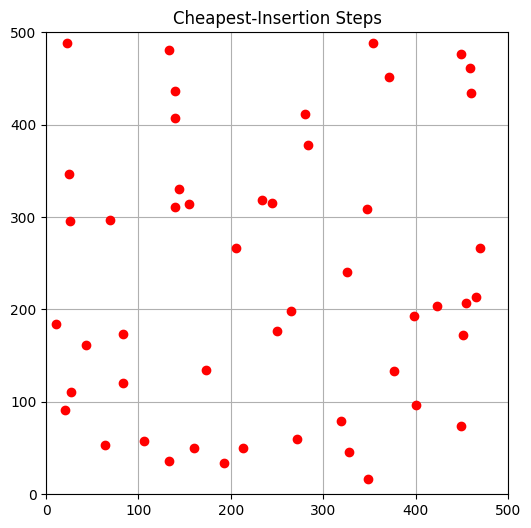

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Prepare frames: show all candidates, then highlight the selected one:
frames = []
for (centroids, candidates, best_idx, prev_c, next_c) in history:
    frames.append(("candidates", centroids, candidates, best_idx))
    frames.append(("selected",   centroids, candidates, best_idx))
coords = cities.cities
# set up plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(coords[:,0], coords[:,1], 'ro')
ax.set_xlim(0, 500)
ax.set_ylim(0, 500)
ax.set_aspect('equal')
ax.grid(True)
ax.set_title("Cheapest‑Insertion Steps")

# pre‑allocate lines
max_variants = max(len(cands) for _,cands,_,_,_ in history)
grey_lines = [ax.plot([], [], alpha=0.3, color='gray')[0]
              for _ in range(max_variants)]
best_line  = ax.plot([], [], 'k-', lw=2)[0]

def init():
    for ln in grey_lines: ln.set_data([], [])
    best_line.set_data([], [])
    return grey_lines + [best_line]

def update(frame_i):
    mode, centroids, candidates, best_idx = frames[frame_i]
    # clear
    for ln in grey_lines: ln.set_data([], [])
    best_line.set_data([], [])

    if mode == "candidates":
        for idx, (perm, cost) in enumerate(candidates):
            tour = perm.copy()
            cycle = tour + [tour[0]]
            xs = centroids[cycle,0]
            ys = centroids[cycle,1]
            grey_lines[idx].set_data(xs, ys)
    else:  # "selected"
        perm, cost = candidates[best_idx]
        tour = perm.copy()
        cycle = tour + [tour[0]]
        xs = centroids[cycle,0]
        ys = centroids[cycle,1]
        best_line.set_data(xs, ys)

    return grey_lines + [best_line]

ani = FuncAnimation(fig, update,
                    frames=len(frames),
                    init_func=init,
                    blit=True,
                    interval=800,
                    repeat=False)

# display inline
HTML(ani.to_jshtml())

# (optional) save to GIF
ani.save("cheapest_insertion.gif", writer="pillow", fps=5)
